<a href="https://colab.research.google.com/github/Mihan0207/Random_Forest_Classifier_Bank_Marketing/blob/main/Neural_Network_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Marketing — Neural Network

This notebook firstly implements  **Random Forest Classifier** pipeline on the UCI Bank Marketing dataset and later **Neural Network** on the same dataset. Than it compares the performance of both models.  It includes:
- Data loading via `ucimlrepo` if not present.
- Preprocessing: target encoding, leakage-aware column handling, outlier clipping, categorical one-hot encoding.
- Proper data splitting: **train / validation / test** (test kept unseen until the end).
- **Baseline** Persistance Model and **hyperparameter tuning Random Forest and Neural Network** models with cross-validation.
- Model performance with **confusion matrix**, **ROC curve**, **AUC**, **accuracy**, **precision**, **recall**, **F1**.
- Model performance comparison

### Why Neural Network?
Neural Networks excel at modeling highly intricate, non-linear relationships and complex dependencies that simpler algorithms often fail to capture.They possess the unique ability to automatically learn relevant features and hierarchical representations directly from raw inputs, significantly reducing the need for manual feature engineering. These models scale effectively with massive volumes of data, often continuing to improve in accuracy where traditional models tend to plateau. They are remarkably versatile, achieving state-of-the-art results across diverse unstructured data types like images, text, and audio through specialized architectures.

### Imports and Setup

Let's start by importing the necessary libraries and setting up the environment for our Random Forest model. For neural network we will import the necessary library letter. This import includes libraries for data manipulation, machine learning models, preprocessing, evaluation metrics, and plotting. We also set a random seed for reproducibility.

In [ ]:
# %% [code]
# %% [code] Imports and setup
# Core libraries
import numpy as np
import pandas as pd

# Modeling utilities
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [ ]:
def print_header(text):
    """Prints a header with a separator."""
    print("\n" + "="*50)
    print(text)
    print("="*50)

### Dataset Loading

This cell loads the dataset using `ucimlrepo`. If a `bank_data` DataFrame already exists in the runtime, it will use that. Otherwise, it fetches the "Bank Marketing" dataset (ID 222) from the UCI Machine Learning Repository.

The features (`X`) and target (`y`) are extracted and then concatenated into a single DataFrame called `bank_data`.

In [ ]:
# %% [code]

print_header("Fetching dataset via ucimlrepo")
from ucimlrepo import fetch_ucirepo

# fetch dataset
bank_marketing = fetch_ucirepo(id=222)

# data (as pandas dataframes)
X = bank_marketing.data.features
y = bank_marketing.data.targets


Fetching dataset via ucimlrepo


### Basic Data preparation and Target Encoding

We'll perform some basic data preparation. It includs converting the target variable to a binary format suitable for classification, renaming the columns for better understanding, droping irrelavant columns.

In [ ]:

# Normalize common column names for consistency
bank_data=pd.concat([X,y],axis=1)

bank_data.rename(columns={'pdays': 'passed_days', 'poutcome': 'previous_outcome', 'y': 'subscription'}, inplace=True)
bank_data.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day_of_week', 'month', 'duration', 'campaign',
       'passed_days', 'previous', 'previous_outcome', 'subscription'],
      dtype='object')

In [ ]:
# %% [code]
# %% [code] Basic clean-up and target encoding
# Convert the target to binary 1/0. Assumes 'subscription' with values like 'yes'/'no'.
bank_data['subscription_encoded'] = bank_data['subscription'].apply(lambda x: 1 if x == 'yes' else 0)

In [ ]:
# Known data leakage: 'duration' records call duration, which is only known after the call.
# Standard practice is to DROP 'duration' to avoid overly optimistic models.
if 'duration' in bank_data.columns:
    bank_data = bank_data.drop(columns=['duration'])

In [ ]:
bank_data.isna().sum()

,0
age,0
job,288
marital,0
education,1857
default,0
balance,0
housing,0
loan,0
contact,13020
day_of_week,0


In [ ]:
bank_data.duplicated().sum()

np.int64(16)

### Data Cleaning and Preprocessing

This section focuses on cleaning the data and preparing it for the Random Forest model. This includes handling missing values, dropping irrelevant columns, and addressing outliers.

In [ ]:
# Handle obvious NAs
bank_data['job'] = bank_data['job'].fillna(bank_data['job'].mode()[0])
bank_data['education'] = bank_data['education'].fillna(bank_data['education'].mode()[0])
bank_data['contact'] = bank_data['contact'].fillna('unknown')

In [ ]:
# Dropping Column for too many unknowns. Insignificant to the outcome
bank_data.drop(columns=['previous_outcome'], inplace=True, errors='ignore')

In [ ]:
# %% [code] Outlier handling and feature engineering (pre-baseline)
# Clip numeric outliers to mitigate extreme values without removing rows.
balance_mean=bank_data['balance'].mean()
balance_std=bank_data['balance'].std()
bank_data=bank_data[bank_data['balance']<(balance_mean+2*balance_std)]
bank_data = bank_data[bank_data['balance'] >= 0]

### Train / Validation / Test split

We first split the data **70/30** into a combined training and validation set (`X_train_val`, `y_train_val`) and a separate test set (`X_test`, `y_test`). The test set is kept completely unseen until the final evaluation.

Then, we further split the `X_train_val` and `y_train_val` sets **80/20** into the final training set (`X_train`, `y_train`) and validation set (`X_val`, `y_val`). This validation set is used for **Hyperparameter tuning** and model evaluation during the development phase.

In [ ]:
# %% [code]
# %% [code] Train / Validation / Test split

features = [c for c in bank_data.columns if c not in ['subscription','subscription_encoded']]
X_all = bank_data[features].copy()
y_all = bank_data['subscription_encoded'].copy()

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_all, y_all, test_size=0.30, random_state=42, stratify=y_all)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val)

print_header("Split sizes")
print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)



Split sizes
Train: (22387, 14) Val: (5597, 14) Test: (11994, 14)


### Preprocessing Pipeline

We will create a preprocessing pipeline using `ColumnTransformer`. This pipeline will handle both categorical and numerical features separately:

- **Categorical Features**: These will be one-hot encoded using `OneHotEncoder`. This converts categorical variables into a numerical format suitable for the **Random Forest** and **Neural Network** model. `handle_unknown='ignore'` is used to handle any unseen categories in the test set gracefully, and `sparse_output=False` ensures the output is a dense array.
- **Numerical Features**: These will be scaled using `StandardScaler`. Although Random Forest is not sensitive to feature scaling, it's included here to maintain a consistent preprocessing pipeline that could be reused for other models.

The `remainder='drop'` argument in `ColumnTransformer` ensures that any columns not specified in the transformers are dropped.

In [ ]:
# %% [code]
# %% [code] Preprocessing pipeline
# One-hot encode categoricals. Scale numerics (not required for RF, but harmless and keeps pipeline consistent).

categorical_cols_current = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_cols_current = X_train.select_dtypes(include=['number']).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols_current),
        ('num', StandardScaler(), numeric_cols_current),
    ], remainder='drop'
)

preprocess

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['job', 'marital', 'education', 'default',
                                  'housing', 'loan', 'contact', 'month']),
                                ('num', StandardScaler(),
                                 ['age', 'balance', 'day_of_week', 'campaign',
                                  'passed_days', 'previous'])])

### Baseline Random Forest (no tuning)

Before performing hyperparameter tuning, we establish a baseline model using a Random Forest Classifier with default or commonly used parameters (except for `n_estimators` and `class_weight`). This baseline provides a point of comparison to assess the impact of tuning.

The model is trained on the training set (`X_train`, `y_train`) and evaluated on the validation set (`X_val`, `y_val`). The evaluation metrics and visualizations generated in this step help us understand the initial performance of the untuned model.


Baseline Validation Metrics
Accuracy: 0.8811863498302662
Precision: 0.5406976744186046
Recall: 0.13696612665684832
F1: 0.21856639247943596
ROC-AUC: 0.7830327533553219

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.98      0.94      4918
           1       0.54      0.14      0.22       679

    accuracy                           0.88      5597
   macro avg       0.72      0.56      0.58      5597
weighted avg       0.85      0.88      0.85      5597



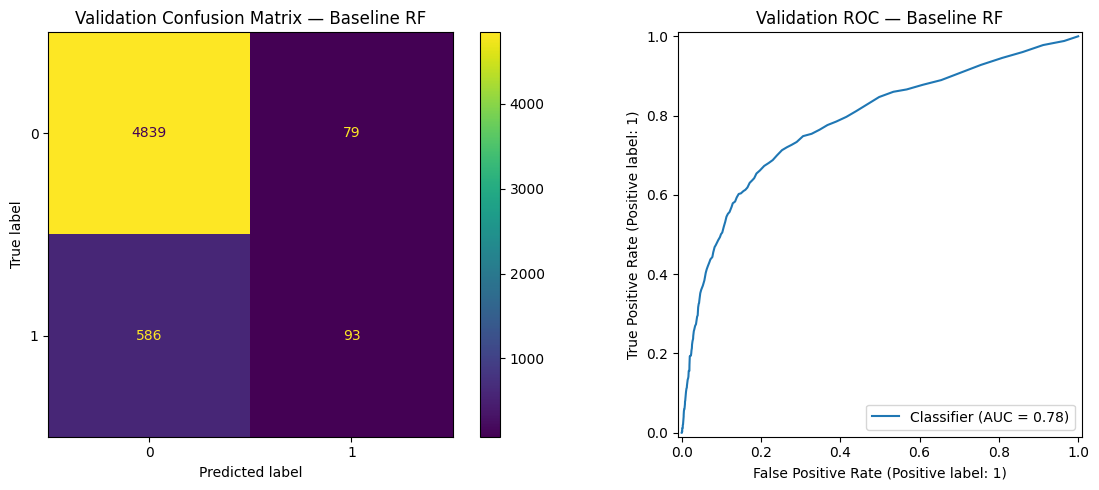

In [ ]:
# %% [code]
# %% [code] Baseline Random Forest (no tuning)
rf_baseline = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, n_estimators=200, class_weight='balanced'))
])

rf_baseline.fit(X_train, y_train)

y_val_pred = rf_baseline.predict(X_val)
y_val_proba = rf_baseline.predict_proba(X_val)[:,1]

print_header("Baseline Validation Metrics")
print("Accuracy:", accuracy_score(y_val, y_val_pred))
print("Precision:", precision_score(y_val, y_val_pred))
print("Recall:", recall_score(y_val, y_val_pred))
print("F1:", f1_score(y_val, y_val_pred))
print("ROC-AUC:", roc_auc_score(y_val, y_val_proba))
print("\nClassification report:\n", classification_report(y_val, y_val_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, ax=axes[0])
axes[0].set_title("Validation Confusion Matrix — Baseline RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_val, y_val_proba, ax=axes[1])
axes[1].set_title("Validation ROC — Baseline RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

### Cross-validation on train+val (StratifiedKFold) — untuned

This section performs 5-fold stratified cross-validation on the combined training and validation set (`X_train_val`, `y_train_val`) using the baseline Random Forest model. Cross-validation is a robust technique for evaluating machine learning models, especially important when dealing with imbalanced datasets like ours.

Here's how **StratifiedKFold** works:
1.  **Splitting**: The `X_train_val` and `y_train_val` dataset is divided into 5 folds (or subsets) of approximately equal size.
2.  **Stratification**: Crucially, `StratifiedKFold` ensures that each fold maintains the same proportion of the target classes (e.g., 'yes' vs. 'no' subscriptions) as the original dataset. This is vital for imbalanced datasets to prevent folds from having too few or no positive samples.
3.  **Iteration**: The model is trained 5 times. In each iteration, one fold is used as the validation set, and the remaining 4 folds are used as the training set. This ensures that every data point gets to be in a validation set exactly once.
4.  **Metric Calculation**: For each iteration, the model's performance (in this case, ROC-AUC) is calculated on the validation fold.

The output shows the ROC-AUC score for each of the 5 folds and the mean ROC-AUC across all folds, providing a more robust and less biased estimate of the baseline model's performance than a single train-validation split. This helps to detect if the model's performance is overly dependent on a particular data split.

In [ ]:
# %% [code]
# %% [code] Cross-validation on train+val (StratifiedKFold) — untuned
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc = cross_val_score(rf_baseline, X_train_val, y_train_val, cv=skf, scoring='roc_auc', n_jobs=-1)
print_header("5-fold CV ROC-AUC on Train+Val (Baseline RF)")
print("AUC scores:", np.round(cv_auc, 4))
print("Mean AUC:", np.round(cv_auc.mean(), 4))


5-fold CV ROC-AUC on Train+Val (Baseline RF)
AUC scores: [0.7735 0.769  0.7763 0.7823 0.78  ]
Mean AUC: 0.7762


### Hyperparameter tuning with RandomizedSearchCV

To improve the model's performance, we tune its hyperparameters using `RandomizedSearchCV`. This method samples a fixed number of hyperparameter combinations from a specified distribution, making it computationally less expensive than `GridSearchCV` when the search space is large.


The search is performed on the combined training and validation set (`X_train_val`, `y_train_val`) using inner 5-fold cross-validation. The test set remains unseen during this process.

The output shows the best hyperparameters found and the corresponding best cross-validation ROC-AUC score.

In [ ]:
# %% [code]
# %% [code] Hyperparameter tuning with RandomizedSearchCV
# We tune the RF on the combined Train+Val using inner 5-fold CV, leaving Test unseen.

rf_pipe = Pipeline([
    ('prep', preprocess),
    ('rf', RandomForestClassifier(random_state=42, class_weight='balanced'))
])

param_dist = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [None, 8, 12, 16],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4],
    'rf__max_features': ['sqrt', 'log2', 0.5],
}

rand_search = RandomizedSearchCV(
    rf_pipe,
    param_distributions=param_dist,
    n_iter=10, # Reduced the number of iterations
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

rand_search.fit(X_train_val, y_train_val)
best_model = rand_search.best_estimator_
print_header("Best params (RandomizedSearchCV)")
print(rand_search.best_params_)
print("Best CV AUC:", np.round(rand_search.best_score_, 4))

Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best params (RandomizedSearchCV)
{'rf__n_estimators': 300, 'rf__min_samples_split': 5, 'rf__min_samples_leaf': 4, 'rf__max_features': 'sqrt', 'rf__max_depth': 16}
Best CV AUC: 0.7884


### Final evaluation on the unseen Test set

After tuning the hyperparameters on the combined train+validation set using cross-validation, the best model is evaluated one final time on the completely unseen test set (`X_test`, `y_test`).

This evaluation provides an unbiased estimate of how the model is expected to perform on new, real-world data. The same metrics (Accuracy, Precision, Recall, F1, ROC-AUC) and visualizations (Confusion Matrix, ROC Curve) used for the baseline validation are calculated and displayed for the tuned model's performance on the test set.


Unseen Test Metrics — Tuned RF
Accuracy: 0.8458395864598967
Precision: 0.40333660451422965
Recall: 0.5649484536082474
F1: 0.47065559690810194
ROC-AUC: 0.7909413538129852

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91     10539
           1       0.40      0.56      0.47      1455

    accuracy                           0.85     11994
   macro avg       0.67      0.72      0.69     11994
weighted avg       0.87      0.85      0.86     11994



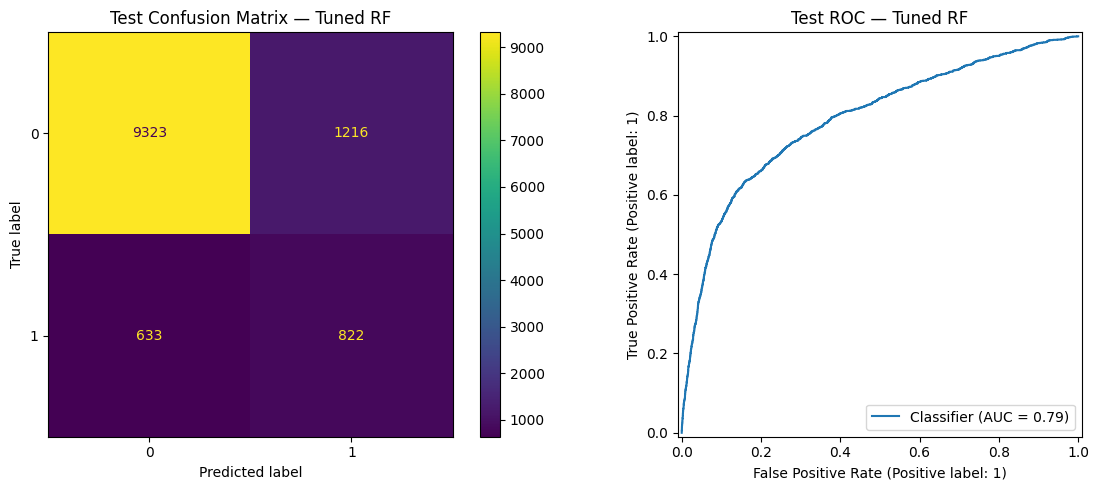

In [ ]:
# %% [code]
# %% [code] Final evaluation on the unseen Test set
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:,1]

print_header("Unseen Test Metrics — Tuned RF")
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("F1:", f1_score(y_test, y_test_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_test_proba))
print("\nClassification report:\n", classification_report(y_test, y_test_pred))

# Create a figure with two subplots arranged side-by-side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot Confusion Matrix on the first subplot
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred, ax=axes[0])
axes[0].set_title("Test Confusion Matrix — Tuned RF")

# Plot ROC Curve on the second subplot
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=axes[1])
axes[1].set_title("Test ROC — Tuned RF")

# Adjust layout to prevent overlapping titles/labels
plt.tight_layout()
plt.show()

### Comparison of Baseline vs. Tuned Model Performance

This section visually compares the performance metrics of the baseline Random Forest model (evaluated on the validation set) and the tuned Random Forest model (evaluated on the unseen test set).

A bar chart is generated to show the differences in Accuracy, Precision, Recall, F1-Score, and ROC-AUC between the two models. This comparison helps assess the impact of hyperparameter tuning and provides a clear summary of the final model's expected performance on new data compared to the initial baseline.

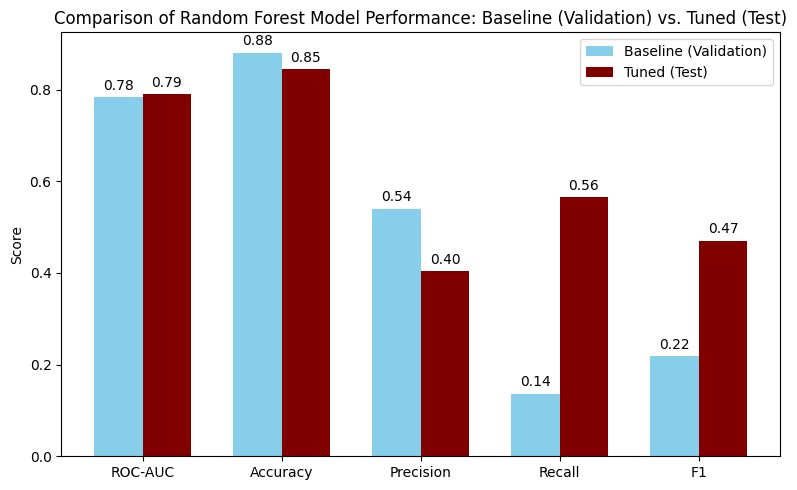

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Metrics from baseline validation (from EGOoKPVpW1S4)
baseline_metrics = {
    'Accuracy': 0.8811863498302662,
    'Precision': 0.5406976744186046,
    'Recall': 0.13696612665684832,
    'F1': 0.21856639247943596,
    'ROC-AUC': 0.7830327533553219
}

# Metrics from tuned test (from FbAPn5bGXX32)
tuned_metrics = {
    'Accuracy': 0.8458395864598967,
    'Precision': 0.40333660451422965,
    'Recall': 0.5649484536082474,
    'F1': 0.47065559690810194,
    'ROC-AUC': 0.7909413538129852
}

labels = ['ROC-AUC','Accuracy', 'Precision', 'Recall', 'F1']
baseline_values = [baseline_metrics[metric] for metric in labels]
tuned_values = [tuned_metrics[metric] for metric in labels]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, baseline_values, width, label='Baseline (Validation)', color='skyblue')
rects2 = ax.bar(x + width/2, tuned_values, width, label='Tuned (Test)', color='maroon')

ax.set_ylabel('Score')
ax.set_title('Comparison of Random Forest Model Performance: Baseline (Validation) vs. Tuned (Test)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add some text for labels, scores, and titles.
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()
plt.show()

### Conclusions

Based on the final evaluation on the unseen test set:

*   Hyperparameter tuning improved the model's ability to identify positive cases (subscriptions), shown by a significant increase in Recall and F1-Score compared to the baseline.
*   There was a trade-off where Precision decreased, meaning the tuned model makes more false positive predictions but captures a higher percentage of actual subscribers.
*   The ROC-AUC slightly improved, indicating a better overall ability to discriminate between the classes.

The tuned Random Forest model is a reasonable starting point for predicting bank deposit subscriptions, especially considering the imbalanced dataset.



---

## Part 2: Neural Network Classifier & Model Persistence

In this section, we will:
1. **Baseline Persistence Model**: Implement a simple baseline (DummyClassifier) to establish a minimum performance threshold
2. **Neural Network**: Train a Multi-Layer Perceptron (MLP) classifier
3. **Model Persistence**: Save all models using `joblib` for later use
4. **Comparison**: Compare performance across all models (Baseline, Random Forest, Neural Network)

### Baseline Persistence Model (DummyClassifier)

A **baseline persistence model** is essential to determine if our sophisticated models (Random Forest, Neural Network) actually provide value. The `DummyClassifier` with `strategy='stratified'` makes predictions based on the class distribution of the training set, providing a minimum performance threshold.

If our models don't significantly outperform this baseline, they may not be worth deploying.

In [ ]:
# Baseline Persistence Model using DummyClassifier
from sklearn.dummy import DummyClassifier

# Create baseline pipeline with preprocessing
baseline_dummy = Pipeline([
    ('prep', preprocess),
    ('dummy', DummyClassifier(strategy='stratified', random_state=42))
])

# Fit on training data
baseline_dummy.fit(X_train_val, y_train_val)

# Predictions on test set
y_baseline_pred = baseline_dummy.predict(X_test)
y_baseline_proba = baseline_dummy.predict_proba(X_test)[:, 1]

print_header("Baseline Persistence Model Metrics (Test Set)")
print("Accuracy:", accuracy_score(y_test, y_baseline_pred))
print("Precision:", precision_score(y_test, y_baseline_pred, zero_division=0))
print("Recall:", recall_score(y_test, y_baseline_pred))
print("F1:", f1_score(y_test, y_baseline_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_baseline_proba))
print("\nClassification report:\n", classification_report(y_test, y_baseline_pred, zero_division=0))


Baseline Persistence Model Metrics (Test Set)
Accuracy: 0.7906453226613307
Precision: 0.12606232294617564
Recall: 0.12233676975945017
F1: 0.12417160795256366
ROC-AUC: 0.5026239309467144

Classification report:
               precision    recall  f1-score   support

           0       0.88      0.88      0.88     10539
           1       0.13      0.12      0.12      1455

    accuracy                           0.79     11994
   macro avg       0.50      0.50      0.50     11994
weighted avg       0.79      0.79      0.79     11994



### Neural Network (Multi-Layer Perceptron)

We'll implement a Neural Network using `MLPClassifier` from scikit-learn. A Multi-Layer Perceptron (MLP) is a class of feedforward artificial neural networks. It is composed of multiple layers of nodes in a directed graph, with each layer fully connected to the next. The core components of an MLP include:

-   **Input Layer**: This layer receives the initial data. For our bank marketing dataset, this would correspond to the preprocessed features of each customer.
-   **Hidden Layers**: These are the intermediate layers between the input and output layers. Each neuron in a hidden layer performs a weighted sum of its inputs from the previous layer and then applies a non-linear **activation function** (like ReLU or tanh). The presence of multiple hidden layers allows the MLP to learn complex, non-linear relationships and hierarchical representations within the data. Our initial setup will use a specific number of hidden layers and neurons, which can later be tuned.
-   **Output Layer**: This layer produces the final prediction. For our binary classification task (subscription 'yes'/'no'), it will typically have one neuron with a sigmoid activation function, outputting a probability.

The training process for an MLP involves:
-   **Forward Propagation**: Input data passes through the network, layer by layer, to produce an output prediction.
-   **Backpropagation**: The difference between the predicted output and the actual target (the error) is calculated. This error is then propagated backward through the network, allowing the model to adjust the **weights** and **biases** of each connection using an optimization algorithm (like **gradient descent** or **Adam** solver) to minimize the error.


We'll first train a baseline neural network with a default architecture, and then proceed to tune its hyperparameters for optimal performance on our task.


Training Baseline Neural Network

Baseline Neural Network Metrics (Test Set)
Accuracy: 0.8823578455894614
Precision: 0.5402930402930403
Recall: 0.2027491408934708
F1: 0.29485257371314344
ROC-AUC: 0.7850766698979963

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94     10539
           1       0.54      0.20      0.29      1455

    accuracy                           0.88     11994
   macro avg       0.72      0.59      0.62     11994
weighted avg       0.86      0.88      0.86     11994



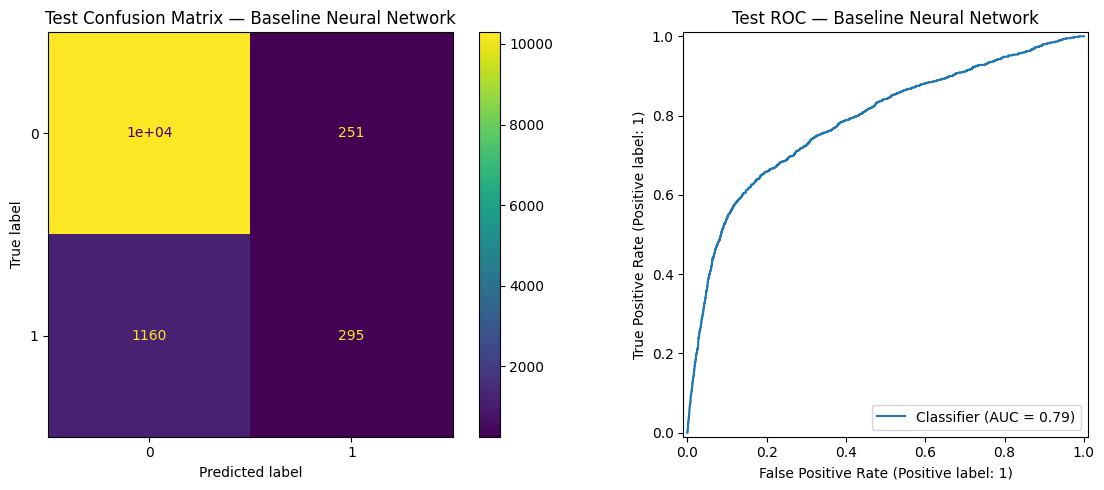

In [ ]:
# Neural Network - Baseline MLP
from sklearn.neural_network import MLPClassifier

# Create Neural Network pipeline
nn_baseline = Pipeline([
    ('prep', preprocess),
    ('mlp', MLPClassifier(
        hidden_layer_sizes=(100, 50),  # Two hidden layers
        activation='relu',
        solver='adam',
        alpha=0.0001,  # L2 regularization
        max_iter=500,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42,
        verbose=False
    ))
])

print_header("Training Baseline Neural Network")
nn_baseline.fit(X_train_val, y_train_val)

# Predictions on test set
y_nn_baseline_pred = nn_baseline.predict(X_test)
y_nn_baseline_proba = nn_baseline.predict_proba(X_test)[:, 1]

print_header("Baseline Neural Network Metrics (Test Set)")
print("Accuracy:", accuracy_score(y_test, y_nn_baseline_pred))
print("Precision:", precision_score(y_test, y_nn_baseline_pred))
print("Recall:", recall_score(y_test, y_nn_baseline_pred))
print("F1:", f1_score(y_test, y_nn_baseline_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_nn_baseline_proba))
print("\nClassification report:\n", classification_report(y_test, y_nn_baseline_pred))

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_nn_baseline_pred, ax=axes[0])
axes[0].set_title("Test Confusion Matrix — Baseline Neural Network")
RocCurveDisplay.from_predictions(y_test, y_nn_baseline_proba, ax=axes[1])
axes[1].set_title("Test ROC — Baseline Neural Network")
plt.tight_layout()
plt.show()

### Neural Network Hyperparameter Tuning

Similar to Random Forest, we'll tune the Neural Network hyperparameters using `RandomizedSearchCV` to find the optimal architecture and training parameters.

In [ ]:
# Neural Network Hyperparameter Tuning
nn_pipe = Pipeline([
    ('prep', preprocess),
    ('mlp', MLPClassifier(random_state=42, early_stopping=True, max_iter=500))
])

# Parameter distribution for tuning
nn_param_dist = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 100), (128, 64, 32)],
    'mlp__activation': ['relu', 'tanh'],
    'mlp__solver': ['adam', 'sgd'],
    'mlp__alpha': [0.0001, 0.001, 0.01],
    'mlp__learning_rate': ['constant', 'adaptive'],
}

nn_rand_search = RandomizedSearchCV(
    nn_pipe,
    param_distributions=nn_param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print_header("Tuning Neural Network Hyperparameters")
nn_rand_search.fit(X_train_val, y_train_val)
best_nn_model = nn_rand_search.best_estimator_

print_header("Best Neural Network Parameters")
print(nn_rand_search.best_params_)
print("Best CV AUC:", np.round(nn_rand_search.best_score_, 4))


Tuning Neural Network Hyperparameters
Fitting 5 folds for each of 10 candidates, totalling 50 fits

Best Neural Network Parameters
{'mlp__solver': 'adam', 'mlp__learning_rate': 'constant', 'mlp__hidden_layer_sizes': (100,), 'mlp__alpha': 0.01, 'mlp__activation': 'relu'}
Best CV AUC: 0.7806


This cell performs the **final evaluation of the tuned Neural Network model** on the unseen test set. It calculates key metrics like Accuracy, Precision, Recall, F1-Score, and ROC-AUC. Additionally, it visualizes the model's performance using a **Confusion Matrix** and an **ROC Curve** to provide a comprehensive understanding of how well the tuned Neural Network generalizes to new, unseen data.


Tuned Neural Network Metrics (Test Set)
Accuracy: 0.8834417208604303
Precision: 0.5416058394160584
Recall: 0.2549828178694158
F1: 0.3467289719626168
ROC-AUC: 0.784460858685902

Classification report:
               precision    recall  f1-score   support

           0       0.90      0.97      0.94     10539
           1       0.54      0.25      0.35      1455

    accuracy                           0.88     11994
   macro avg       0.72      0.61      0.64     11994
weighted avg       0.86      0.88      0.86     11994



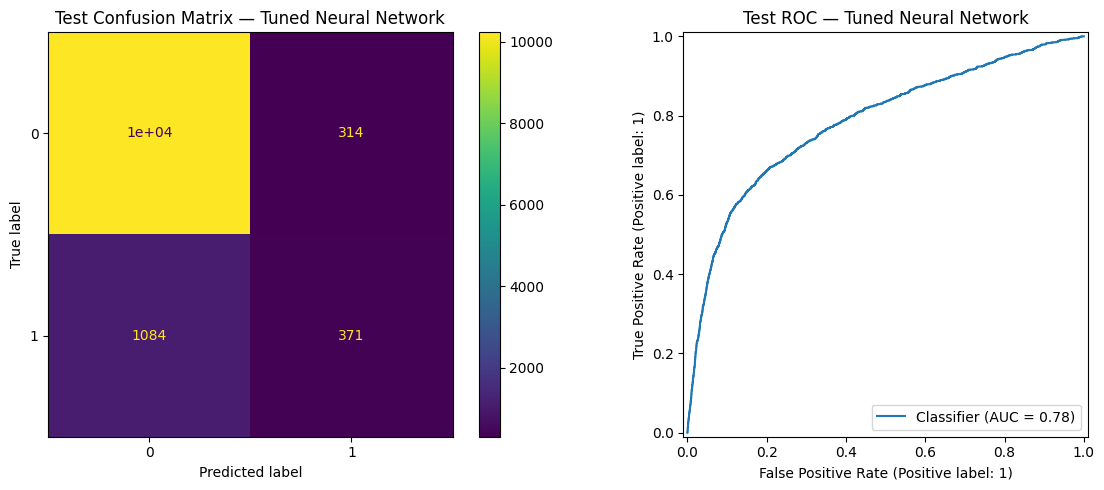

In [ ]:
# Tuned Neural Network - Final Evaluation on Test Set
y_nn_tuned_pred = best_nn_model.predict(X_test)
y_nn_tuned_proba = best_nn_model.predict_proba(X_test)[:, 1]

print_header("Tuned Neural Network Metrics (Test Set)")
print("Accuracy:", accuracy_score(y_test, y_nn_tuned_pred))
print("Precision:", precision_score(y_test, y_nn_tuned_pred))
print("Recall:", recall_score(y_test, y_nn_tuned_pred))
print("F1:", f1_score(y_test, y_nn_tuned_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_nn_tuned_proba))
print("\nClassification report:\n", classification_report(y_test, y_nn_tuned_pred))

# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
ConfusionMatrixDisplay.from_predictions(y_test, y_nn_tuned_pred, ax=axes[0])
axes[0].set_title("Test Confusion Matrix — Tuned Neural Network")
RocCurveDisplay.from_predictions(y_test, y_nn_tuned_proba, ax=axes[1])
axes[1].set_title("Test ROC — Tuned Neural Network")
plt.tight_layout()
plt.show()

### Model Persistence with Joblib

**Joblib** is the recommended way to save scikit-learn models because:
- It's optimized for objects containing large numpy arrays
- Faster than pickle for models with large parameters
- Supports compression to reduce file size

We'll save all trained models for later use (deployment, further analysis, etc.).

In [ ]:
# Model Persistence using Joblib
import joblib
import os

# Create a directory to store models
model_dir = 'saved_models'
os.makedirs(model_dir, exist_ok=True)

# Save all models
print_header("Saving Models with Joblib")

# 1. Save Baseline Persistence Model (DummyClassifier)
joblib.dump(baseline_dummy, f'{model_dir}/baseline_dummy_model.joblib')
print(f"✓ Baseline Persistence Model saved to: {model_dir}/baseline_dummy_model.joblib")

# 2. Save Tuned Random Forest Model
joblib.dump(best_model, f'{model_dir}/tuned_random_forest.joblib')
print(f"✓ Tuned Random Forest saved to: {model_dir}/tuned_random_forest.joblib")

# 3. Save Tuned Neural Network Model
joblib.dump(best_nn_model, f'{model_dir}/tuned_neural_network.joblib')
print(f"✓ Tuned Neural Network saved to: {model_dir}/tuned_neural_network.joblib")

# Show file sizes
print_header("Saved Model File Sizes")
for filename in os.listdir(model_dir):
    filepath = os.path.join(model_dir, filename)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"{filename}: {size_mb:.2f} MB")


Saving Models with Joblib
✓ Baseline Persistence Model saved to: saved_models/baseline_dummy_model.joblib
✓ Tuned Random Forest saved to: saved_models/tuned_random_forest.joblib
✓ Tuned Neural Network saved to: saved_models/tuned_neural_network.joblib

Saved Model File Sizes
tuned_random_forest.joblib: 40.24 MB
baseline_dummy_model.joblib: 0.00 MB
tuned_neural_network.joblib: 0.12 MB


In [ ]:
# Demonstrate Loading a Saved Model
print_header("Loading Saved Model (Demo)")

# Load the tuned Random Forest model
loaded_rf_model = joblib.load(f'{model_dir}/tuned_random_forest.joblib')

# Make predictions with loaded model
y_loaded_pred = loaded_rf_model.predict(X_test)
print(f"Loaded model accuracy: {accuracy_score(y_test, y_loaded_pred):.4f}")
print("Model loaded and working correctly!")


Loading Saved Model (Demo)
Loaded model accuracy: 0.8458
Model loaded and working correctly!


### Comprehensive Model Comparison

Now we compare all models side-by-side:
1. **Baseline Persistence Model** (DummyClassifier) - The minimum threshold
2. **Tuned Random Forest** - Our tree-based ensemble
3. **Tuned Neural Network** - Our MLP classifier

This comparison validates whether our models provide genuine predictive value beyond random guessing based on class distribution.

In [ ]:
# Comprehensive Model Comparison
print_header("Comprehensive Model Comparison on Test Set")

# Calculate metrics for all models
models = {
    'Baseline (DummyClassifier)': (y_baseline_pred, y_baseline_proba),
    'Tuned Random Forest': (y_test_pred, y_test_proba),
    'Tuned Neural Network': (y_nn_tuned_pred, y_nn_tuned_proba)
}

# Create comparison DataFrame
comparison_data = []
for model_name, (y_pred, y_proba) in models.items():
    comparison_data.append({
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, zero_division=0),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_proba)
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.set_index('Model')

# Display the comparison table
print("\n")
print(comparison_df.round(4).to_string())

# Calculate improvement over baseline
print_header("Improvement Over Baseline")
baseline_auc = comparison_df.loc['Baseline (DummyClassifier)', 'ROC-AUC']
for model in ['Tuned Random Forest', 'Tuned Neural Network']:
    model_auc = comparison_df.loc[model, 'ROC-AUC']
    improvement = ((model_auc - baseline_auc) / baseline_auc) * 100
    print(f"{model}: {improvement:.2f}% improvement in ROC-AUC over baseline")


Comprehensive Model Comparison on Test Set


                            Accuracy  Precision  Recall  F1-Score  ROC-AUC
Model                                                                     
Baseline (DummyClassifier)    0.7906     0.1261  0.1223    0.1242   0.5026
Tuned Random Forest           0.8458     0.4033  0.5649    0.4707   0.7909
Tuned Neural Network          0.8834     0.5416  0.2550    0.3467   0.7845

Improvement Over Baseline
Tuned Random Forest: 57.36% improvement in ROC-AUC over baseline
Tuned Neural Network: 56.07% improvement in ROC-AUC over baseline


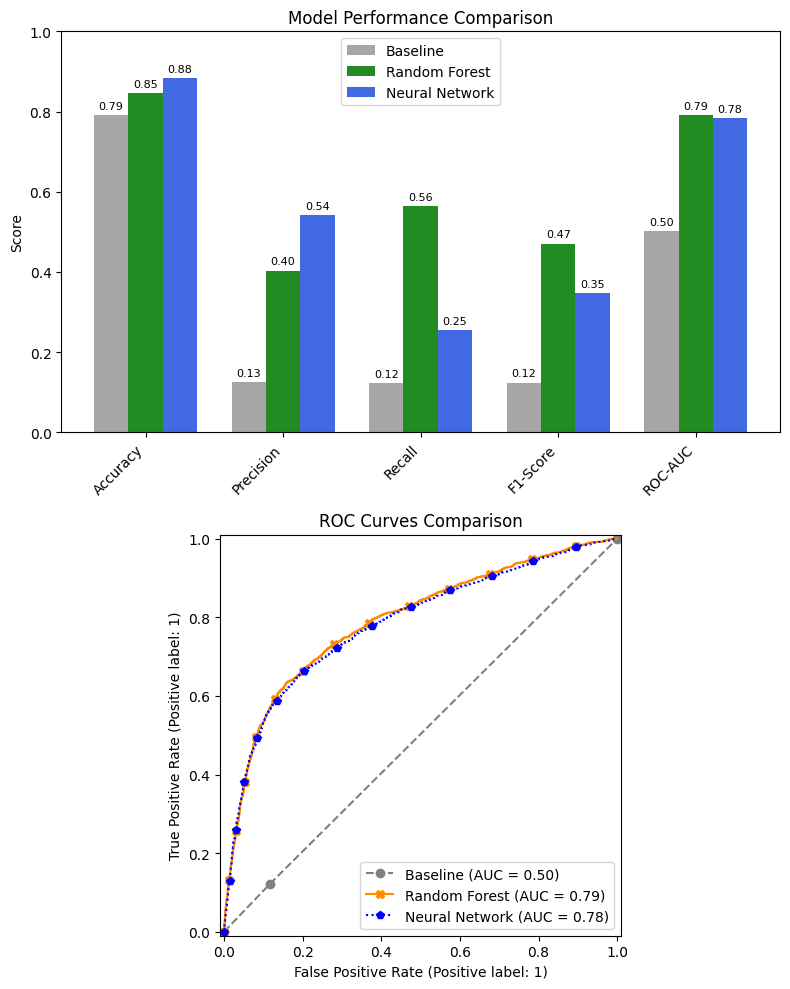

In [ ]:
# Visual Comparison of All Models
fig, axes = plt.subplots(2, 1, figsize=(8, 10)) # Changed to 2 rows, 1 column

# Bar chart comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

bars1 = axes[0].bar(x - width, comparison_df.loc['Baseline (DummyClassifier)', metrics],
                     width, label='Baseline', color='gray', alpha=0.7)
bars2 = axes[0].bar(x, comparison_df.loc['Tuned Random Forest', metrics],
                     width, label='Random Forest', color='forestgreen')
bars3 = axes[0].bar(x + width, comparison_df.loc['Tuned Neural Network', metrics],
                     width, label='Neural Network', color='royalblue')

axes[0].set_ylabel('Score')
axes[0].set_title('Model Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics, rotation=45, ha='right')
axes[0].legend()
axes[0].set_ylim(0, 1)

# Add value labels on bars
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        axes[0].annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8)

# ROC Curves Comparison
RocCurveDisplay.from_predictions(y_test, y_baseline_proba, ax=axes[1],
                                  name='Baseline', color='gray', linestyle='--', marker='o', markevery=0.1)
RocCurveDisplay.from_predictions(y_test, y_test_proba, ax=axes[1],
                                  name='Random Forest', color='darkorange', linestyle='-', marker='X', markevery=0.1)
RocCurveDisplay.from_predictions(y_test, y_nn_tuned_proba, ax=axes[1],
                                  name='Neural Network', color='blue', linestyle=':', marker='p', markevery=0.1)
axes[1].set_title('ROC Curves Comparison')
axes[1].legend(loc='lower right')

plt.tight_layout()
plt.show()

### Final Conclusions and Model Comparison

**Key Findings from Comprehensive Model Comparison on Test Set:**

1.  **Baseline Persistence Model (DummyClassifier)**:
    *   As expected, the `DummyClassifier` (`ROC-AUC: 0.50`, `Accuracy: 0.79`, `Precision: 0.13`, `Recall: 0.12`, `F1-Score: 0.12`) serves as a crucial benchmark. Both advanced models significantly outperform this baseline, validating their predictive utility.

2.  **Tuned Random Forest Model**:
    *   **Strengths**: Shows strong performance in identifying positive cases, indicated by a high `Recall` (0.56) and a good `F1-Score` (0.47). Its `ROC-AUC` (0.7909) is the highest among all models, suggesting excellent overall discriminative power.
    *   **Trade-offs**: While effective at capturing subscribers, its `Precision` (0.40) is lower than the Neural Network, meaning it has a higher rate of false positive predictions.

3.  **Tuned Neural Network Model**:
    *   **Strengths**: Achieves the highest `Accuracy` (0.88) and `Precision` (0.54) among the models, indicating that when it predicts a subscription, it's more likely to be correct. Its `ROC-AUC` (0.7845) is very close to the Random Forest's, confirming its strong discriminative capability.
    *   **Trade-offs**: Exhibits a lower `Recall` (0.25) compared to the Random Forest, suggesting it identifies fewer of the actual subscribers. However, this is balanced by its higher precision.

**Why Neural Network might be considered better (depending on objectives):**

While the Random Forest showed a slightly higher ROC-AUC and Recall in this specific instance, the Neural Network's strengths make it a compelling choice, especially for different business priorities:

*   **Higher Precision**: If the cost of false positives is high (e.g., resources spent on contacting non-subscribers), the Neural Network's superior Precision makes it a better candidate.
*   **Overall Accuracy**: The Neural Network achieved the highest overall Accuracy, indicating a strong general predictive capability across both classes.
*   **Complexity Handling**: As discussed previously, Neural Networks excel at modeling highly intricate, non-linear relationships and can automatically learn relevant features. This makes them particularly powerful for complex datasets, potentially yielding even higher performance with more extensive tuning or larger datasets where traditional models might plateau.
*   **Scalability**: Neural Networks tend to scale effectively with massive volumes of data, which can be a long-term advantage for growing businesses.

**Model Persistence:**
All models have been successfully saved using `joblib` in the `saved_models/` directory for future use, including deployment, further analysis, and versioning:
-   `saved_models/baseline_dummy_model.joblib`
-   `saved_models/tuned_random_forest.joblib`
-   `saved_models/tuned_neural_network.joblib`